# Week 8 Exercises

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [3]:
import numpy as np
import pandas

import random

import thinkstats2
import thinkplot

In [4]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

In [5]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [6]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")

In [7]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [8]:
class DiffMeansOneSided(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

In [9]:
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [10]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [11]:
class DiceTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

In [12]:
class DiceChiTest(DiceTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

In [13]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

## Exercises

**Exercise 9-1:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [14]:
# Solution

def RunTests(live, iters=1000): # RunTests is a function that runs mutliple test from exercises in chapter 9
    """Runs the tests from Chapter 9 with a subset of the data.

    live: DataFrame
    iters: how many iterations to run
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # comparing pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

I would not have though to create a function to run all the tests, but this actually makes the most sense and I think is a very pythonic was of completing the task

In [15]:
n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2

9148	0.16	0.00	0.00	0.00
4574	0.19	0.00	0.00	0.00
2287	0.72	0.00	0.00	0.00
1143	0.27	0.15	0.05	0.00
571	0.04	0.09	0.06	0.05
285	0.39	0.02	0.00	0.17
142	0.85	0.57	0.35	0.84


In [16]:
#Results:

# test1: difference in mean pregnancy length
# test2: difference in mean birth weight
# test3: correlation of mother's age and birth weight
# test4: chi-square test of pregnancy length

# n     test1   test2   test2   test4
# 9148	0.16	0.00	0.00	0.00
# 4574	0.19	0.00	0.00	0.00
# 2287	0.72	0.00	0.00	0.00
# 1143	0.27	0.15	0.05	0.00
# 571	0.04	0.09	0.06	0.05
# 285	0.39	0.02	0.00	0.17
# 142	0.85	0.57	0.35	0.84

# It seems that as sample size 'n' is decreased the pvalue is increasing. An increased pvalue means that the difference 
# is not statistically significant


**Exercise 10-1:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [17]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [18]:
import brfss

df = brfss.ReadBrfss(nrows=None) # Assigns the brfss data to variable df
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights) # Uses the log base 10 function on weights and assigns to variable "log_weights"

Estimation of intercept and slope

In [19]:
inter, slope = thinkstats2.LeastSquares(heights, log_weights) # Usese the least squear function provided by thinkstats2 to 
# Calculate the intercept and slope
inter, slope

(0.9930804163932863, 0.005281454169417785)

Creating a scatter plot of heights and log_logweights

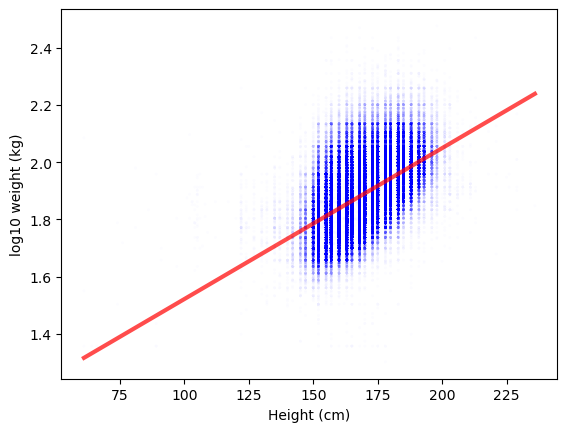

In [20]:
thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5) # Scatter plot function provided by thinkstats2/thnikplot
fxs, fys = thinkstats2.FitLine(heights, inter, slope) # Adds fitline to scatterplot
thinkplot.Plot(fxs, fys, color='red') # Colors line
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False) # Creates labels 

Same plot but removing the log weights and using weights unchanged

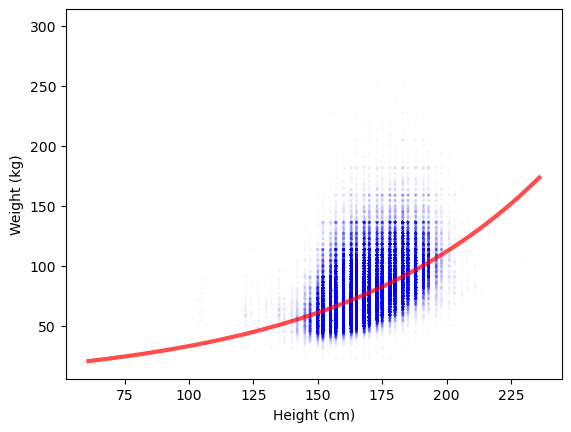

In [21]:
thinkplot.Scatter(heights, weights, alpha=0.01, s=5) # Here the weights variable was used instead of log_weights
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

Plotting percentiles of the residuals

In [22]:
res = thinkstats2.Residuals(heights, log_weights, inter, slope) # Using thinkstats function for residuals
df['residual'] = res

In [23]:
type(res) # checking the type of variable res

numpy.ndarray

In [24]:
res # showing the values saved to the variable res

array([ 0.02843876,  0.00775614, -0.02381385, ...,  0.0254324 ,
        0.12756024, -0.058118  ])

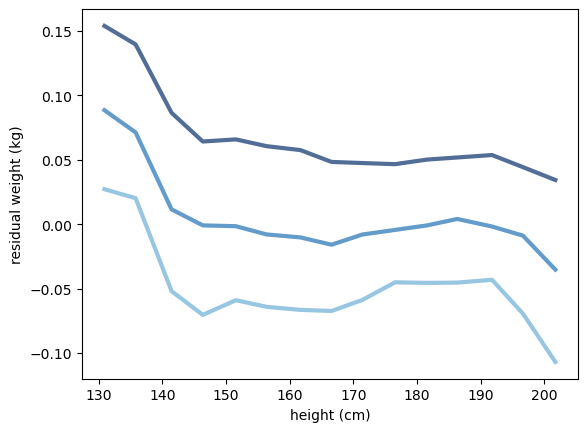

In [25]:
bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

Calculating correlation

In [26]:
rho = thinkstats2.Corr(heights, log_weights) # Using the function provided by thinkstats2 to calculate 
# the correlation coefficient of heights and log_weights
rho # displaying the value

0.5317282605983433

Calculate coefficient of determination

In [27]:
r2 = thinkstats2.CoefDetermination(log_weights, res) # Coefficient Determintaion function provided in exercise
r2

0.282734943118939

Interpretting this value requires changing it to a percentage. The percentage is about 28%, which means that 28% of the data falls along the regression line

Confirm that  𝑅2=𝜌2

In [28]:
np.isclose(rho**2, r2)

True

Calculate Std(ys), which is the RMSE of predictions that don't use height.

In [29]:
std_ys = thinkstats2.Std(log_weights) # Using the thinkstats2 standard deviation on log_weights to 
# calculate the Root Mean Square Error
std_ys

0.10320725030004888

Calculate Std(res), the RMSE of predictions that do use height.

In [30]:
std_res = thinkstats2.Std(res) # This is calcualting the standard deveation of the residuals
std_res

0.0874077708041609

How much does height information reduce RMSE?

In [31]:
1 - std_res / std_ys

0.15308497658793352

Use resampling to compute sampling distributions for inter and slope.

In [32]:
t = [] 
for _ in range(100):
    sample = thinkstats2.ResampleRows(df) # The thinkstats2 resample function was provided in the exercises
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

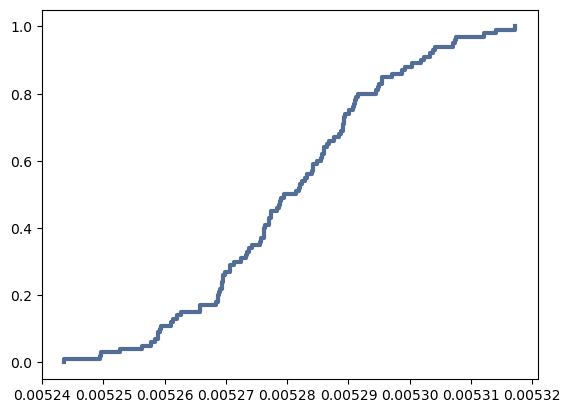

In [33]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf) # Using the CDF plot function to plot the resampled data, runnign the cell again would genreate a slightly 
# different plot

Calculate the p-value of the slope.

In [34]:
pvalue = cdf[0]
pvalue

0

Calculate the 90% confidence interval of slope.

In [35]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.005256235509763452, 0.005307033663993164)

Calculate the mean of the sampling distribution.

In [36]:
mean = thinkstats2.Mean(slopes) 
mean

0.005280698053618759

Compute the standard deviation of the sampling distribution, which is the standard error.

In [37]:
stderr = thinkstats2.Std(slopes)
stderr

1.530168495730898e-05

Resample rows without weights, compute mean height, and summarize results.

In [38]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov 

In [39]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [40]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [41]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)] # Resamples the df
Summarize(estimates_unweighted) # Uses the summarize function provided in the exercises

mean, SE, CI 168.9549032165161 0.01572207340177 (168.93311303785444, 168.98194183390933)


Resample rows with weights. Note that the weight column in this dataset is called finalwt.

In [42]:
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.49538753814747 0.016347143561323954 (170.46825168253199, 170.51882616867763)


There is a clear difference in mean between the unweighted and weighted esitmates. There is a differnece of 2 between 168(unweighted) and 170(weighted).